In [6]:
import math

def phi(x):
    return (1 / math.sqrt(2 * math.pi)) * math.exp(-0.5 * x**2)

def CDF(x):
    return 0.5 * (1 + math.erf(x / math.sqrt(2)))

In [80]:
import numpy as np

def ImpliedVolatility(S, K, r, T, C_mkt):

    # ATM Formula — Brenner & Subrahmanyam, for calls when r ≈ 0)
        #sigma_cur = (2 * np.pi) ** 0.5 * (C_mkt / (S * T ** 0.5))
    # Standard 80% volatility
        sigma_cur = 0.5

        for i in range(10):
            d_1 = (np.log(S / K) + (r + 0.5 * sigma_cur ** 2) * T) / (sigma_cur * T ** 0.5)
            d_2 = d_1 - sigma_cur * T ** 0.5
            vega = S * T ** 0.5 * phi(d_1)
            C_bs = S * CDF(d_1) - K * np.exp(-r * T) * CDF(d_2)
        
            sigma_new = sigma_cur - ((C_bs - C_mkt) / vega)
    
            sigma_cur = sigma_new
        
        return sigma_cur

In [59]:
instrument_name = "BTC-26DEC25-110000-C"   # you picked this from the list

# Now fetch live market data for it
ticker = deribit("public/ticker", {"instrument_name": instrument_name})

S = ticker["index_price"]     # Underlying BTC index price
C_mkt = ticker["settlement_price"]  # Mid-market option price

print("Underlying spot price S:", S)
print("Market option price C_mkt:", C_mkt * S)

print(ticker)

Underlying spot price S: 113738.51
Market option price C_mkt: 9639.4399497739
{'timestamp': 1761497701532, 'state': 'open', 'stats': {'high': 0.0945, 'low': 0.083, 'price_change': 12.5, 'volume': 15.9, 'volume_usd': 151501.72}, 'greeks': {'delta': 0.63159, 'gamma': 2e-05, 'vega': 176.70804, 'theta': -64.63301, 'rho': 102.63417}, 'index_price': 113738.51, 'instrument_name': 'BTC-26DEC25-110000-C', 'last_price': 0.0945, 'settlement_price': 0.08475089, 'min_price': 0.06, 'max_price': 0.137, 'open_interest': 2015.6, 'mark_price': 0.0943, 'best_bid_price': 0.0935, 'best_ask_price': 0.095, 'interest_rate': 0.0, 'mark_iv': 44.35, 'underlying_price': 114995.36, 'underlying_index': 'BTC-26DEC25', 'bid_iv': 43.84, 'ask_iv': 44.82, 'estimated_delivery_price': 113738.51, 'best_ask_amount': 0.5, 'best_bid_amount': 11.6}


In [67]:
import requests, datetime

def getBtcData():
    BASE = "https://www.deribit.com/api/v2"
    
    def deribit(method, params=None):
        r = requests.get(f"{BASE}/{method}", params=params or {}, timeout=10)
        r.raise_for_status()
        return r.json()["result"]
    
    instruments = deribit("/public/get_instruments", {
        "base_currency": "BTC",
        "counter_currency" : "USD",
        "kind": "option",
    })
    
    # 2) Pick by expiry date and strike
    target_expiry = datetime.date(2025, 12, 26)     # <-- set what you want
    target_strike = 110000                           # <-- set what you want
    target_type = "C"                                # "C" call, "P" put
    
    # Deribit instrument name pattern: BTC-DMMMYY-STRIKE-C/P
    def match(inst):
        ts = datetime.datetime.utcfromtimestamp(inst["expiration_timestamp"]/1000).date()
        return (ts == target_expiry and
                int(inst["strike"]) == target_strike and
                inst["option_type"].upper().startswith({"call":"C","put":"P"}.get("call" if target_type=="C" else "put")))
    
    instrument = next(inst for inst in instruments if match(inst))
    inst_name = instrument["instrument_name"]
    
    # 3) Get prices (C_mkt = mark_price; S = index_price) and time to expiry
    tick = deribit("public/ticker", {"instrument_name": inst_name})
    S = tick["index_price"]
    C_mkt = tick["mark_price"]
    
    expiry_ts = instrument["expiration_timestamp"] / 1000
    T_days = (datetime.datetime.utcfromtimestamp(expiry_ts) - datetime.datetime.utcnow()).total_seconds() / 86400.0
    T_years = T_days / 365.0
    
    print("Instrument:", inst_name)
    print("S (index price):", S)
    print("K (strike):", target_strike)
    print("C_mkt (mark price):", C_mkt * S)
    print("Time to expiration: {:.4f} years ({} days)".format(T_years, int(round(T_days))))

    return(S, K, C_mkt * S, T_years)

In [4]:
def CalculateCallPrice(S, K, r, T, C_mkt):

    vol = ImpliedVolatility(S, K, r, T, C_mkt)
    
    dt = T/N
    nudt = (r - 0.5 * np.square(vol)) * dt
    volsdt = vol * np.sqrt(dt)
    lnS = np.log(S)

    # SE placeholders
    sum_CT = 0
    sum_CT2 = 0

    # Monte Carlo Simulation
    for i in range(M):
        lnSt = lnS
        for j in range (N):
            lnSt = lnSt + nudt + volsdt * np.random.normal()

        ST = np.exp(lnSt)
        CT = max(0, ST - K)
        sum_CT = sum_CT + CT
        sum_CT2 = sum_CT2 + CT*CT

    C0 = np.exp(-r * T) * sum_CT / M
    sigma = np.sqrt( (sum_CT2 - sum_CT * sum_CT / M) * np.exp(-2 * r * T) / (M - 1) )
    SE = sigma / np.sqrt(M)

    #print("Call value is ${0} with SE +/- {1}".format(np.round(C0, 2), np.round(SE, 2)))

In [86]:
def CalculateCallPriceVector(S, K, r, T, C_mkt):
    # precompute constants
    vol = ImpliedVolatility(S, K, r, T, C_mkt)


    dt = T/N
    nudt = (r - 0.5 * vol ** 2) * dt
    volsdt = vol * np.sqrt(dt)
    lnS = np.log(S)

    # Monte Carlo Method
    Z = np.random.normal(size = (N, M))
    delta_lnSt = nudt + volsdt * Z
    lnSt = lnS + np.cumsum(delta_lnSt, axis = 0)
    lnSt = np.concatenate( (np.full(shape = (1, M), fill_value = lnS), lnSt ) )

    # Compute Expectation and SE
    ST = np.exp(lnSt)
    CT = np.maximum(0, ST - K)
    C0 = np.exp(-r * T) * np.sum(CT[-1]) / M

    sigma = np.sqrt( np.sum( (CT[-1] - C0)**2) / (M-1) )
    SE = sigma / np.sqrt(M)

    single_path = np.exp(lnSt[:, 0])  # Take the first simulated path
    
    return np.round(C0, 2), np.round(SE, 2), single_path
    
    # print("Call value is ${0} with SE +/- {1}".format(np.round(C0, 2), np.round(SE, 2)))

In [68]:
getBtcData()

Instrument: BTC-26DEC25-110000-C
S (index price): 113555.77
K (strike): 110000
C_mkt (mark price): 10594.753341
Time to expiration: 0.1661 years (61 days)


(113555.77, 100000, 10594.753341, 0.16609883593661212)

In [82]:
S = 111026
K = 100000
C_mkt = 11059
T = 1 / 365
r = 0.01
N = 10
M = 1000

CalculateCallPriceVector(S, K, r, T, C_mkt)

C0_vector = np.zeros(M)
SE_vector = np.zeros(M)
ST_matrix = np.zeros((N + 1, M))   # each column = one St path over time

for i in range(M):
    C0, SE, St_path = CalculateCallPriceVector(S, K, r, T, C_mkt)
    C0_vector[i] = C0
    SE_vector[i] = SE
    ST_matrix[:, i] = St_path   # ✅ put the whole path into column i
    
print("Done.")
print("C0 mean:", np.mean(C0_vector))
print("SE mean:", np.mean(SE_vector))
print("ST_matrix shape:", ST_matrix.shape)   # (N+1, 1000)

#for i in range(N + 1):
#    print(ST_matrix[i][0])

Done.
C0 mean: 11063.159099999999
SE mean: 169.75719
ST_matrix shape: (11, 1000)


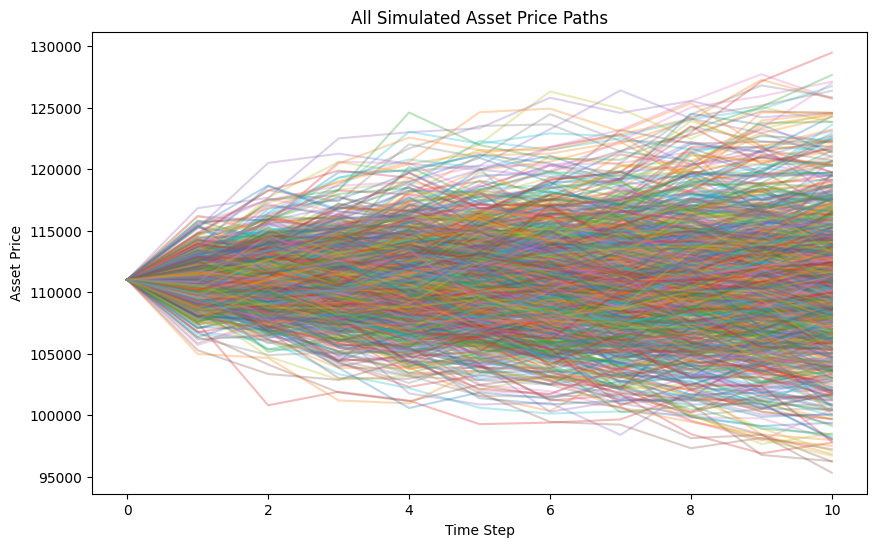

In [83]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))  # Makes the plot larger; can remove if desired

for i in range(ST_matrix.shape[1]):   # Loop over each column (each simulation path)
    plt.plot(ST_matrix[:, i], alpha=0.3)  # alpha adds transparency so lines don't completely overlap

plt.title("All Simulated Asset Price Paths")
plt.xlabel("Time Step")
plt.ylabel("Asset Price")
plt.show()

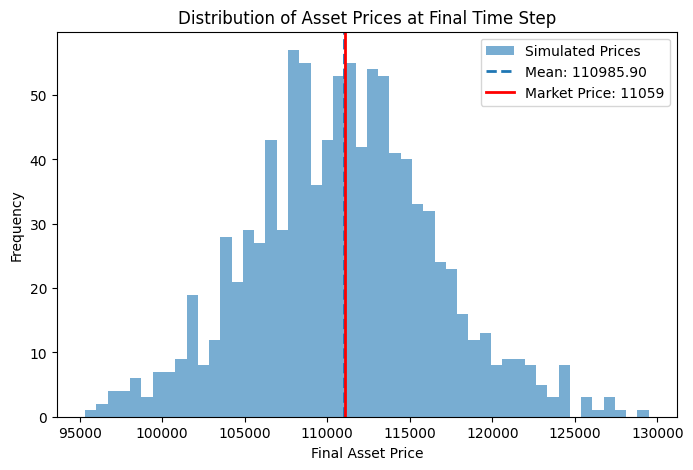

In [84]:
import matplotlib.pyplot as plt
import numpy as np

# Extract final simulated prices
final_prices = ST_matrix[-1, :]

# Calculate statistics
mean_final_price = np.mean(final_prices)

# Plot histogram
plt.figure(figsize=(8,5))
plt.hist(final_prices, bins=50, alpha=0.6, label='Simulated Prices')

# Add vertical lines
plt.axvline(mean_final_price, linestyle='dashed', linewidth=2, label=f"Mean: {mean_final_price:.2f}")
plt.axvline(C_mkt + K, color='red', linestyle='solid', linewidth=2, label=f"Market Price: {C_mkt}")

# Add labels and legend
plt.title("Distribution of Asset Prices at Final Time Step")
plt.xlabel("Final Asset Price")
plt.ylabel("Frequency")
plt.legend()
plt.show()